# Experiment 3

This program creates graphs that have undergone degree-based filtering and k-core decomposition. In addition, it creates a graph that has undergone only random sampling, which can be considered the most naive implementation for reducing the size.

# Import librarly

In [1]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import numpy as np
import random

# Read dataset

In [2]:
# Do not separate by a comma if there is no space after the comma
# If you use a regular expression as a delimiter, you need to specify the Python engine
twitterData = pd.read_csv("data.csv", sep=',(?=\S)', engine='python')

twitterData.head()

,id,screenName,tags,avatar,followersCount,friendsCount,lang,lastSeen,tweetId,friends
0,"""1969527638""","""LlngoMakeEmCum_""","[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/534286217...",319,112,"""en""",1472271687519,"""769310701580083200""","[ ""1969574754"", ""1969295556"", ""1969284056"", ""1..."
1,"""51878493""","""_notmichelle""","[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/761977602...",275,115,"""en""",1472270622663,"""769309490038439936""","[ ""60789485"", ""2420931980"", ""2899776756"", ""127..."
2,"""1393409100""","""jesseayye""","[ ""#narcos"" ]","""http://pbs.twimg.com/profile_images/713282938...",120,107,"""en""",1472804144409,"""771622623583186944""","[ ""86868062"", ""19697415"", ""2998836604"", ""45629..."
3,"""232891415""","""MrBrianLloyd""","[ ""#gloryoutnow"" ]","""http://pbs.twimg.com/profile_images/133440668...",492,325,"""en""",1472269186776,"""769308131696467969""","[ ""361335082"", ""1405248468"", ""24626354"", ""7256..."
4,"""710130422907207680""","""sarahdorat_16""","[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/767180520...",128,218,"""en""",1472271397356,"""769309769144283137""","[ ""1571896093"", ""768938323612008448"", ""2548665..."


## Modify dataset

In [3]:
# 1. removing unnecessary double quotes
twitterData["id"] = twitterData["id"].apply(lambda x: x[1:-1])
    
# 2. The list of friends (people followed) is saved as a single string. To convert it to a list of friend IDs, use a JSON loader.
for column in ["tags", "friends"]:
    twitterData[column] = twitterData[column].apply(lambda x: json.loads(x))

# 3. drop unused column for this project
twitterData = twitterData.drop(["lang", 'avatar', 'tweetId', 'screenName', 'lastSeen'], axis=1)

twitterData.head()

,id,tags,followersCount,friendsCount,friends
0,1969527638,[#nationaldogday],319,112,"[1969574754, 1969295556, 1969284056, 196961221..."
1,51878493,[#nationaldogday],275,115,"[60789485, 2420931980, 2899776756, 127410795, ..."
2,1393409100,[#narcos],120,107,"[86868062, 19697415, 2998836604, 456295047, 74..."
3,232891415,[#gloryoutnow],492,325,"[361335082, 1405248468, 24626354, 725675895965..."
4,710130422907207680,[#nationaldogday],128,218,"[1571896093, 768938323612008448, 2548665930, 3..."


In [4]:
twitterData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              40000 non-null  object
 1   tags            40000 non-null  object
 2   followersCount  40000 non-null  int64 
 3   friendsCount    40000 non-null  int64 
 4   friends         40000 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.5+ MB


# Prerpocess

In [5]:
# friends: the list of IDs the user follows
# friendsCount: the length of the friends list
twitterData.describe()

,followersCount,friendsCount
count,4.000000e+04,40000.000000
mean,3.692349e+03,919.101450
std,9.136179e+04,3417.849318
min,1.010000e+02,101.000000
25%,2.420000e+02,253.000000
50%,4.400000e+02,423.000000
75%,9.240000e+02,801.000000
max,1.476555e+07,238749.000000


In [6]:
# create a dictionary to find index from id
id_index_dict = {}
for index, row in twitterData.iterrows():
    id_index_dict[row['id']] = index

In [7]:
# show the number of nodes, edges and the number of communities
def print_graph_summary(G):
    print("Number of nodes: {}".format(G.number_of_nodes()))
    print("Number of edges: {}".format(G.number_of_edges()))
    # detect communities
    communities = list(nx.community.greedy_modularity_communities(G))
    print("Number of communities: {}".format(len(communities)))
    return communities

In [8]:
# create directed graph: the node is the user, the edge is the connection between users
G = nx.DiGraph()
G_rand = nx.DiGraph()

for _, row in twitterData.iterrows():
    for friend in row['friends']:
        # ignore the users who are not in this dataset
        if friend in id_index_dict:
            G.add_edge(row['id'], friend)
            G_rand.add_edge(row['id'], friend)
            
# show the number of nodes and edges
print("Number of nodes: {}".format(G.number_of_nodes()))
print("Number of edges: {}".format(G.number_of_edges()))

Number of nodes: 33734
Number of edges: 184548


### Degree-based filtering:

In [9]:
min_in_degree = 20
filtered_nodes = [node for node, in_degree in G.in_degree() if in_degree >= min_in_degree]
G = G.subgraph(filtered_nodes)

communities = print_graph_summary(G)

Number of nodes: 1633
Number of edges: 25328
Number of communities: 30


### K-Core Decomposition:

In [10]:
k_core = 20
G = nx.k_core(G, k=k_core)

communities = print_graph_summary(G)

Number of nodes: 809
Number of edges: 18034
Number of communities: 6


# Network Characterization

In [11]:
# print number of nodes and edges with format
print("Number of nodes: {}\n".format(G.number_of_nodes()))
print("Number of edges: {}\n".format(G.number_of_edges()))

Number of nodes: 809

Number of edges: 18034



In [12]:
# find the five nodes with the highest clustering coefficients with format
hi_clustring_coeff = sorted(nx.clustering(G).items(), key=lambda x: x[1], reverse=True)[:5]

# find the five nodes with the highest betweenness centrality with format
hi_betweeness_cen = sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)[:5]

In [13]:
# enumerate the five nodes with the highest clustering coefficients
for i, (node, coeff) in enumerate(hi_clustring_coeff):
    # get index from id
    index = id_index_dict[node]
    print("{}. clustering coefficient: {}".format(i+1, coeff))
    # print the row of the node
    print(twitterData.iloc[index])
    print()

1. clustering coefficient: 0.9698331193838254
id                                                         86676024
tags                                              [#nationaldogday]
followersCount                                                 1591
friendsCount                                                    646
friends           [161359752, 762014076054573056, 76200159680903...
Name: 19909, dtype: object

2. clustering coefficient: 0.9688750555802579
id                                               765100688984580096
tags                                              [#nationaldogday]
followersCount                                                  163
friendsCount                                                    206
friends           [695840145543688192, 715448005415952384, 35991...
Name: 11167, dtype: object

3. clustering coefficient: 0.968236582694414
id                                               763645162279100416
tags                                              [#nationa

In [14]:
# enumerate the five nodes with the highest betweenness centrality
for i, (node, betweenness) in enumerate(hi_betweeness_cen):
    # get index from id
    index = id_index_dict[node]
    print("{}. betweenness centrality: {}".format(i+1, betweenness))
    # print the row of the node
    print(twitterData.iloc[index])
    print()

1. betweenness centrality: 0.10507844042274368
id                                                         44967503
tags                                          [#respecttylerjoseph]
followersCount                                                92866
friendsCount                                                  66318
friends           [2193911396, 747510031294267392, 182104983, 41...
Name: 20429, dtype: object

2. betweenness centrality: 0.07048378917600984
id                                                       1963516285
tags                                          [#respecttylerjoseph]
followersCount                                                28453
friendsCount                                                  20113
friends           [716043640645292033, 4810202792, 1365421418, 7...
Name: 12902, dtype: object

3. betweenness centrality: 0.05362057640860556
id                                                         69121313
tags                                          [#respect

In [15]:
# print number of connected components with format
print("Number of connected components: {}".format(nx.number_connected_components(G.to_undirected())))
# print the diameter of the graph with format
for i, component in enumerate(nx.connected_components(G.to_undirected())):
    print("Diameter of the component {}: {}".format(i + 1, nx.diameter(G.subgraph(component).to_undirected())))

Number of connected components: 2
Diameter of the component 1: 6
Diameter of the component 2: 1


### Visualization

In [16]:
# combine the nodes in communities
community_dict = {node: -1 for node in G.nodes()}
community_dict = {node: cid for cid, community in enumerate(communities) for node in community}

# set the color of nodes
colors = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.CSS4_COLORS.keys())
node_color = [colors[community_dict[node] % len(colors)] for node in G.nodes()]

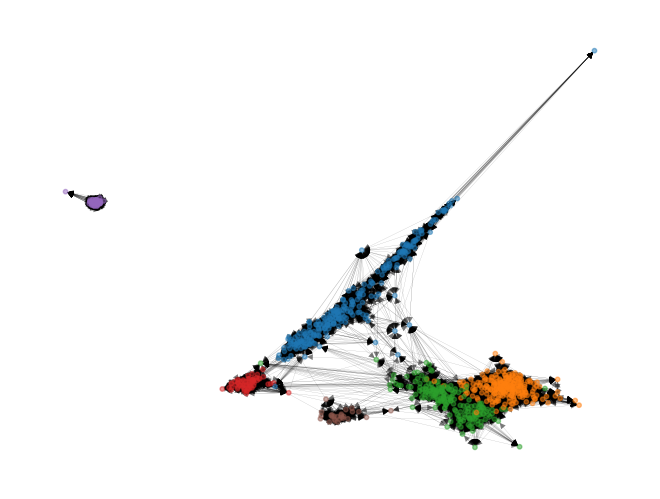

In [17]:
nx.draw(G, node_color=node_color, with_labels=False, node_size=10, alpha=0.5, width=0.1)
plt.show()

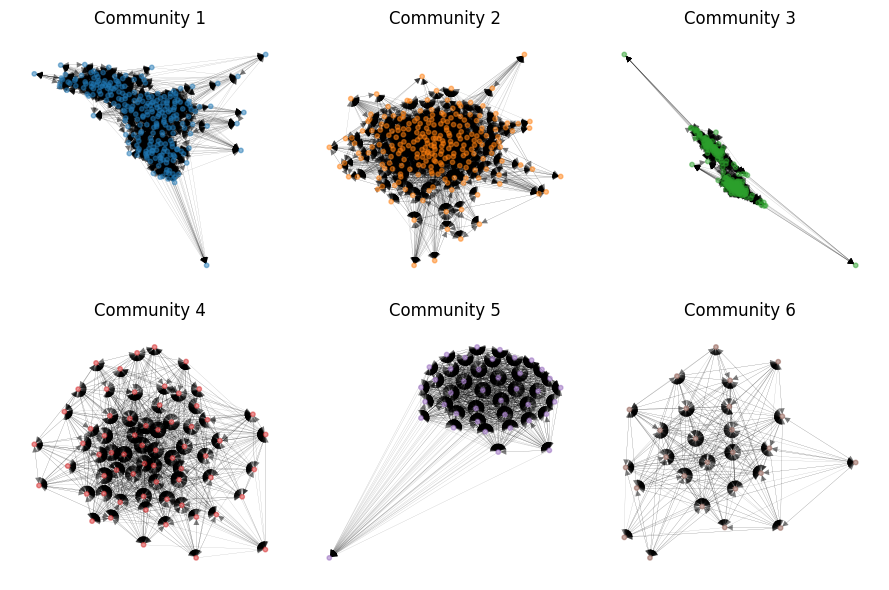

In [18]:
# calculate the number of rows and columns of subplots
n_communities = len(communities)
n_columns = math.ceil(math.sqrt(n_communities))
n_rows = math.ceil(n_communities / n_columns)

# set the size of subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(3 * n_columns, 3 * n_rows))

# draw subgraphs
for i, community in enumerate(communities):
    subgraph = G.subgraph(community)

    # set the color
    subgraph_node_color = [colors[community_dict[node] % len(colors)] for node in subgraph.nodes()]

    ax = axes[i // n_columns, i % n_columns]
    ax.set_title(f"Community {i + 1}")
    nx.draw(subgraph, node_color=subgraph_node_color, with_labels=False, node_size=10, alpha=0.5, width=0.1, ax=ax)

# delete empty subplots
for i in range(n_communities, n_rows * n_columns):
    fig.delaxes(axes[i // n_columns, i % n_columns])

# show the graphs
plt.tight_layout()
plt.show()


In [19]:
# create a list of graph of all communities
graphs = [G.subgraph(community) for community in communities]

# community_tags: the list of sets of tags in each community
# community_ratios: the list of ratios of tags in each community
community_tags = []
community_ratios = []

for i, graph in enumerate(graphs):
    # print the summary of the graph
    print(f"Community {i + 1}")
    print("\tNumber of nodes: {}".format(graph.number_of_nodes()))
    print("\tNumber of edges: {}".format(graph.number_of_edges()))

    # using id_index_dict, get the index of nodes in the graph
    # then, get the tags of the nodes
    # finally, get the set of tags in the graph
    tags = set()
    for node in graph.nodes():
        tags.update(twitterData['tags'][id_index_dict[node]])
        
    # count the number of tags in the graph
    tag_count = {tag: 0 for tag in tags}
    total_count = 0
    for node in graph.nodes():
        for tag in twitterData['tags'][id_index_dict[node]]:
            tag_count[tag] += 1
            total_count += 1

    # sort the tags by the number of appearance
    tag_count = sorted(tag_count.items(), key=lambda x: x[1], reverse=True)
    
    # display the top 3 tags and their ratios
    top_tags = []
    top_ratios = []
    for tag, count in tag_count[:3]:
        ratio = count / total_count * 100
        print(f"\t- {tag}: {ratio:.2f}%")
        top_tags.append(tag)
        top_ratios.append(ratio)

    # if the number of tags is less than 3, add empty strings and 0s
    # to make the length of the list 3
    if len(top_tags) < 3:
        top_tags = top_tags + ["", ""]
        top_ratios = top_ratios + [0, 0]
        
    community_tags.append(top_tags)
    community_ratios.append(top_ratios)

    print()

Community 1
	Number of nodes: 252
	Number of edges: 4740
	- #nationaldogday: 95.29%
	- jorge: 1.18%
	- #weekend: 0.78%

Community 2
	Number of nodes: 235
	Number of edges: 5455
	- #respecttylerjoseph: 95.85%
	- #nationaldogday: 2.07%
	- #strangerthingsseason2: 0.41%

Community 3
	Number of nodes: 191
	Number of edges: 3196
	- #respecttylerjoseph: 81.19%
	- #nationaldogday: 11.88%
	- #youtubeisoverparty: 1.49%

Community 4
	Number of nodes: 65
	Number of edges: 1631
	- #gloryoutnow: 74.07%
	- #britneytoday: 12.35%
	- britney: 9.88%

Community 5
	Number of nodes: 40
	Number of edges: 1476
	- #nationaldogday: 100.00%

Community 6
	Number of nodes: 26
	Number of edges: 446
	- #nationaldogday: 92.86%
	- #respecttylerjoseph: 3.57%
	- #justinssextapeleakedparty: 3.57%



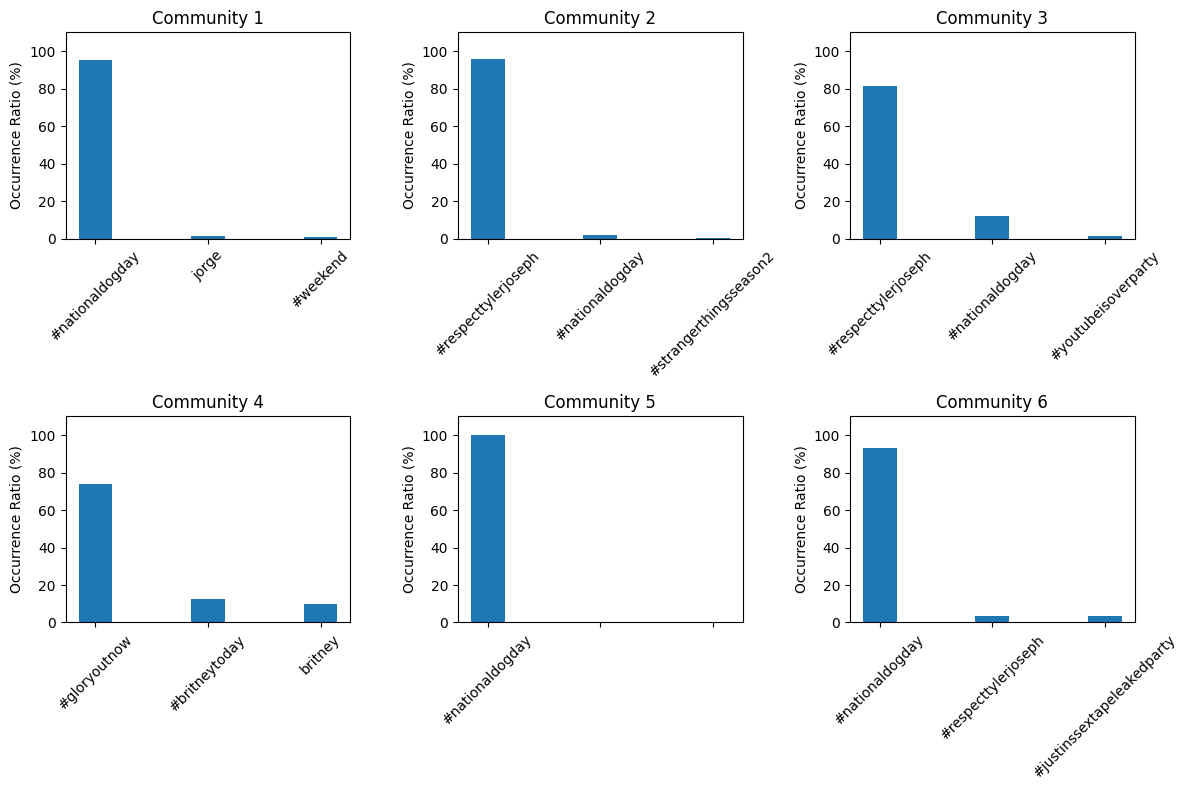

In [20]:
# visualization
n_communities = len(communities)
bar_width = 0.3
index = np.arange(3)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(4 * n_columns, 4 * n_rows))

for i in range(n_communities):
    ax = axes[i // n_columns, i % n_columns]
    ax.bar(index - bar_width / 2, community_ratios[i], width=bar_width, tick_label=community_tags[i])
    ax.set_title(f"Community {i + 1}")
    ax.set_ylim(0, 110)  #  fix the range of y-axis
#     ax.set_xlabel('Hashtags')
    ax.set_ylabel('Occurrence Ratio (%)')
    # rotate the labels of x-axis for readability
    ax.tick_params(axis='x', rotation=45)

# delete empty subplots
for i in range(n_communities, n_rows * n_columns):
    fig.delaxes(axes[i // n_columns, i % n_columns])

plt.tight_layout()
plt.show()

## [Quasi-Experiment] In case using Random Sampling (same number of nodes)

In [21]:
num_sampled_nodes = G.number_of_nodes()
all_nodes = list(G_rand.nodes())
sampled_nodes = random.sample(all_nodes, num_sampled_nodes)
G_rand = G_rand.subgraph(sampled_nodes)

# show the number of nodes and edges
communities = print_graph_summary(G_rand)

Number of nodes: 809
Number of edges: 79
Number of communities: 751


In [22]:
# combine the nodes in communities
community_dict.clear()
community_dict = {node: -1 for node in G_rand.nodes()}
community_dict = {node: cid for cid, community in enumerate(communities) for node in community}

# set the color of nodes
colors = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.CSS4_COLORS.keys())
node_color = [colors[community_dict[node] % len(colors)] for node in G_rand.nodes()]

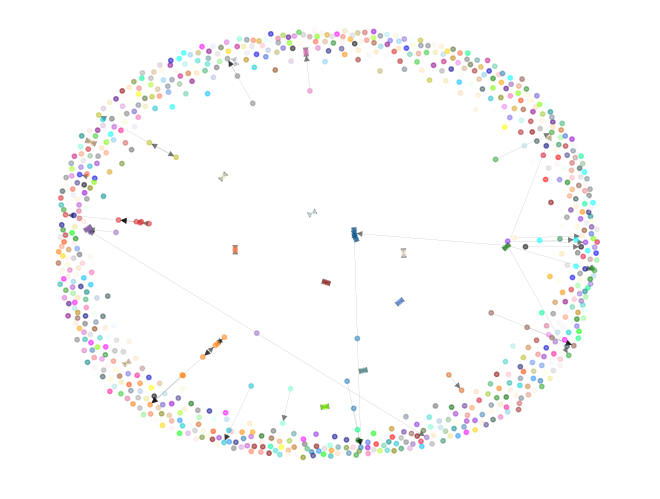

In [23]:
nx.draw(G_rand, node_color=node_color, with_labels=False, node_size=10, alpha=0.5, width=0.1)
plt.show()